In [1]:
import os
import sys
import time

sys.path.append(os.getcwd() + '/../scripts/')

In [2]:
# for interactive plots
#%matplotlib notebook

# else
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.0, 6.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.subplot.bottom'] = .1 

from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
from matplotlib import cm # required for colors

import matplotlib.pyplot as plt

from functools import partial

import numpy as np
np.seterr(all='raise')

from scipy.optimize import minimize

In [3]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'online_adaptive_lrbms': 'DEBUG',
                'OS2015_academic_problem': 'INFO',
                'local_thermalblock_problem': 'INFO',
                'senegal_proceedings_problem': 'INFO',
                'discretize_elliptic': 'INFO',
                'offline': 'INFO',
                'online_enrichment': 'INFO',
                'lrbms': 'INFO',
                'notebook': 'INFO'})
logger = getLogger('notebook.notebook')

# setting up the problem

For $\mu \in \mathcal{P}$, find $u(\mu) \in H^1_0(\Omega)$, s.t.

$- \nabla \cdot \big( \lambda(\mu) \nabla u(\mu) \big) = f$

with

$\begin{align}
\Omega &= [-1, 1]^2,\\
\mathcal{P} &= [0, \pi]^2,\\
f(x, y) &= \tfrac{1}{2} \pi^2 cos(\tfrac{1}{2} \pi x) cos(\tfrac{1}{2} \pi y),\\
\lambda(\mu) &= \theta_0(\mu) \lambda_0 + \theta_1(\mu) \lambda_1,\\
\theta_0(\mu) &= 1.1 + sin(\mu_0)\mu_1,\\
\theta_1(\mu) &= 1.1 + sin(\mu_1),\\
\lambda_0 &= \chi_{\Omega\; \backslash\; ([1/6, 2/6] \times [1/6, 2/6] \;\cup\; [1/6, 2/6] \times [4/6, 5/6])},\\
\lambda_1 &= \chi_{[1/6, 2/6] \times [1/6, 2/6] \;\cup\; [1/6, 2/6] \times [4/6, 5/6]}
\end{align}$

The diffusion is thus given as the linear combination of scaled indicator functions with support inside two blocks in the left half of the domain, roughly where the x is here:

```
+-----------+
|           |
|  x        |
|           |
|  x        |
|           |
+-----------+
```

## and the reference discretization

$P^1$ SWIPDG on conforming simplex grid with 128 simplices.

In [4]:
from senegal_proceedings_problem import init_grid_and_problem

config = {'num_coarse_grid_elements': [8, 8], 
          'num_grid_refinements': 4,
          'num_grid_subdomains': [8, 8], 
          'num_grid_oversampling_layers': 4, # num_grid_oversampling_layers has to exactly cover one subdomain!
          'enrichment_target_error': -1,
          'marking_doerfler_theta': -1,
          'marking_max_age': -1}

grid_and_problem_data = init_grid_and_problem(config)
grid = grid_and_problem_data['grid']
logger.info('... grid has {} elements and {} subdomains'.format(grid.num_elements, grid.num_subdomains))
#grid.visualize('grid', False)

mu_bar = grid_and_problem_data['mu_bar']
parameter_range = grid_and_problem_data['parameter_range']
parameter_range = (parameter_range[0], parameter_range[1])

initial_guess = np.array([0.25, 0.5])

00:00 senegal_proceedings_problem: initializing grid and problem ... 
00:00 notebook: ... grid has 2048 elements and 64 subdomains


In [5]:
from discretize_elliptic import discretize

block_SWIPDG_disc, block_space = discretize(grid_and_problem_data)
block_SWIPDG_disc.disable_logging()

parameter_space = block_SWIPDG_disc.parameter_space
parameter_type = block_SWIPDG_disc.parameter_type
parse_parameter = block_SWIPDG_disc.parse_parameter
mu_bar = parse_parameter(mu_bar)

logger.info('reference discretization has {} DoFs'.format(block_SWIPDG_disc.solution_space.dim))

00:00 discretize_block_SWIPDG: discretizing ... 
01:13 notebook: reference discretization has 6144 DoFs


In [6]:
# this is only required to estimate the target error for the online enrichment
logger.info('estimating some detailed errors ...')
detailed_errors = []

# either 'sweep' over the parameter space
#for mu in parameter_space.sample_uniformly(3):
#    mu = parse_parameter(mu)
#    logger.info('  {}'.format(mu))
#    U = block_SWIPDG_disc.solve(mu)
#    estimate = block_SWIPDG_disc.estimate(U, mu=mu)
#    logger.info('            -> {}'.format(estimate))
#    detailed_errors.append(estimate)

# or picke the maximizing one manually
mu = parse_parameter((np.pi, np.pi/2.))
logger.info('  {}'.format(mu))
U = block_SWIPDG_disc.solve(mu)
estimate = block_SWIPDG_disc.estimate(U, mu=mu)
logger.info('            -> {}'.format(estimate))
detailed_errors.append(estimate)

logger.info('')
logger.info('min/max: {}/{}'.format(np.min(detailed_errors), np.max(detailed_errors)))

01:13 notebook: estimating some detailed errors ...
01:13 notebook:   {diffusion: [3.141592653589793, 1.5707963267948966]}
01:18 notebook:             -> 0.18363747897175975
      
01:18 notebook: min/max: 0.18363747897175975/0.18363747897175975


```
config = {'num_coarse_grid_elements': [8, 8], 
          'num_grid_refinements': 4,
          'num_grid_subdomains': [8, 8], 
          'num_grid_oversampling_layers': 4}

03:58 notebook: estimating some detailed errors ...
03:58 notebook:   {diffusion: [0.0, 0.0]}
04:24 notebook:     -> 0.1357539794692262
04:24 notebook:   {diffusion: [0.0, 1.5707963267948966]}
04:51 notebook:     -> 0.18363747901708638
04:51 notebook:   {diffusion: [0.0, 3.141592653589793]}
05:17 notebook:     -> 0.1357539795227431
05:17 notebook:   {diffusion: [1.5707963267948966, 0.0]}
05:44 notebook:     -> 0.1357539794692262
05:44 notebook:   {diffusion: [1.5707963267948966, 1.5707963267948966]}
06:10 notebook:     -> 0.05861264906935173
06:10 notebook:   {diffusion: [1.5707963267948966, 3.141592653589793]}
06:37 notebook:     -> 0.06489821569030092
06:37 notebook:   {diffusion: [3.141592653589793, 0.0]}
07:03 notebook:     -> 0.1357539794692262
07:03 notebook:   {diffusion: [3.141592653589793, 1.5707963267948966]}
07:29 notebook:     -> 0.18363747897175975
07:29 notebook:   {diffusion: [3.141592653589793, 3.141592653589793]}
07:56 notebook:     -> 0.1357539795567306
      
07:56 notebook: min/max: 0.05861264906935173/0.18363747901708638
```

In [7]:
# as a result of the above, we set
config['enrichment_target_error'] = 1.1*np.max(detailed_errors)

# minimizing using the reference discretization

In [8]:
def compute_value_matrix(f, x, y):
    f_of_x = np.zeros((len(x), len(y)))
    for ii in range(len(x)):
        for jj in range(len(y)):
            f_of_x[ii][jj] = f((x[ii], y[jj]))
    x, y = np.meshgrid(x, y)
    return x, y, f_of_x


def plot_3d_surface(f, x, y):
    X, Y = x, y
    cmaps = [plt.get_cmap(name) for name in ('Purples', 'Oranges', 'Blues')]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    if isinstance(f, (list, tuple)):
        for ii in range(len(f)):
            x, y, f_of_x = compute_value_matrix(f[ii], X, Y)
            ax.plot_surface(x, y, f_of_x, cmap=cmaps[ii%len(cmaps)],
                            linewidth=0, antialiased=False)
    else:
        x, y, f_of_x = compute_value_matrix(f, x, y)
        ax.plot_surface(x, y, f_of_x, cmap=cmaps[0],
                        linewidth=0, antialiased=False)
    ax.view_init(elev=57.7597402597, azim=-59.6370967742)
    ax.set_xlim3d([-0.10457963, 3.2961723])
    ax.set_ylim3d([-0.10457963, 3.29617229])
    #ax.set_zlim3d([ 1.21122592, 4.42022848])
    return ax


def addplot_xy_point_as_bar(ax, x, y, color='orange', z_range=None):
    ax.plot([y, y], [x, x], z_range if z_range else ax.get_zlim(), color)

In [9]:
logger.info('computing some reference quantities of interest ...')

training_set = parameter_space.sample_uniformly(25)
training_set = [mu['diffusion'] for mu in training_set]

def reference_quantity_of_interest(mu):
    return block_SWIPDG_disc.rhs.apply(block_SWIPDG_disc.solve(mu)).data[0]

reference_quantities_of_interest = list()
for mu in training_set:
    reference_quantities_of_interest.append(reference_quantity_of_interest(mu))

logger.info('... done')

01:18 notebook: computing some reference quantities of interest ...
02:02 notebook: ... done


02:02 notebook: plotting ...
02:09 notebook: ... done


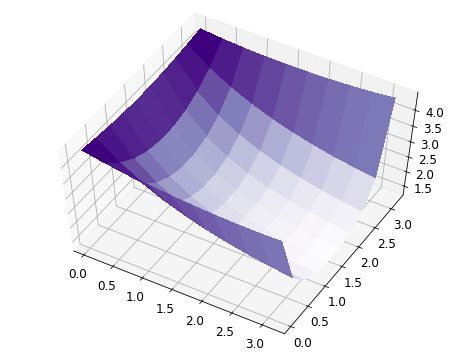

In [10]:
logger.info('plotting ...')

XX = np.linspace(parameter_range[0] + 0.05, parameter_range[1], 10)
YY = XX

plot_3d_surface(reference_quantity_of_interest, XX, YY)

logger.info('... done')

In [11]:
logger.info('minimizing reference quantity of interest:')

reference_minimization_data = {'num_evals': 0,
                               'evaluations' : [],
                               'evaluation_points': []}


def record_results(function, data, mu):
    print('.', end='')
    QoI = function(mu)
    data['num_evals'] += 1
    # we need to make sure to copy the data, since the added mu will be changed inplace by minimize afterwards
    data['evaluation_points'].append([parse_parameter(mu)['diffusion'][:][0], parse_parameter(mu)['diffusion'][:][1]])
    data['evaluations'].append(QoI[0])
    return QoI


def report(result, data):
    if (result.status != 0):
        logger.info(' failed!')
    else:
        logger.info(' succeded!')
        logger.info('  mu_min:    {}'.format(parse_parameter(result.x)))
        logger.info('  QoI(mu_min): {}'.format(result.fun[0]))
        logger.info('  num iterations:     {}'.format(result.nit))
        logger.info('  num function calls: {}'.format(data['num_evals']))


def extended_report(data):
    for kk, vv in data.items():
        logger.info(kk)
        if isinstance(vv, (list, tuple)):
            for v in vv:
                logger.info('  {}'.format(v))
        else:
            logger.info('  {}'.format(vv))
        logger.info('')


result = minimize(partial(record_results, reference_quantity_of_interest, reference_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range, parameter_range),
                  options={'ftol': 1e-15})

report(result, reference_minimization_data)

02:10 notebook: minimizing reference quantity of interest:


................................

02:12 notebook:  succeded!
02:12 notebook:   mu_min:    {diffusion: [1.5709556647769143, 3.141592653589793]}
02:12 notebook:   QoI(mu_min): 1.2440146176507332
02:12 notebook:   num iterations:     7
02:12 notebook:   num function calls: 39


.......

02:12 notebook: plotting chosen points during minimization of reference quantity of interest ...
02:19 notebook: ... done


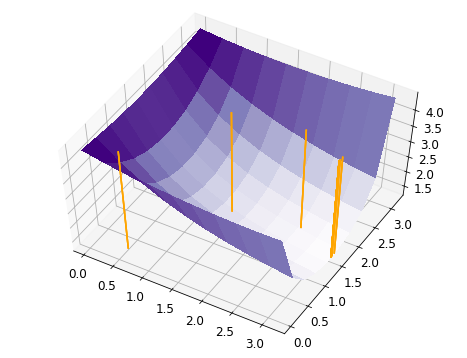

In [12]:
logger.info('plotting chosen points during minimization of reference quantity of interest ...')

reference_plot = plot_3d_surface(reference_quantity_of_interest, XX, YY)

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1])

logger.info('... done')

In [13]:
reference_minimizer = result.x
reference_minimum = result.fun[0]
reference_num_global_solves = reference_minimization_data['num_evals']

logger.info('reference_minimizer: mu = {}'.format(reference_minimizer))
logger.info('reference_minimum: {}'.format(reference_minimum))
logger.info('reference_num_global_solves: {}'.format(reference_num_global_solves))
logger.info('')

extended_report(reference_minimization_data)

02:19 notebook: reference_minimizer: mu = [ 1.57095566  3.14159265]
02:19 notebook: reference_minimum: 1.2440146176507332
02:19 notebook: reference_num_global_solves: 39
      
02:19 notebook: num_evals
02:19 notebook:   39
      
02:19 notebook: evaluations
02:19 notebook:   3.9716123092896556
02:19 notebook:   3.971612294449353
02:19 notebook:   3.9716123004735544
02:19 notebook:   2.020444126959145
02:19 notebook:   2.0204441286987675
02:19 notebook:   2.0204441192141385
02:19 notebook:   1.5068749271819337
02:19 notebook:   1.5068749307174232
02:19 notebook:   1.5068749235615588
02:19 notebook:   1.2482881414594262
02:19 notebook:   1.2482881423306567
02:19 notebook:   1.248288139112053
02:19 notebook:   1.2444337286401332
02:19 notebook:   1.2444337289123315
02:19 notebook:   1.244433726297414
02:19 notebook:   1.2440146176536413
02:19 notebook:   1.2440146176528817
02:19 notebook:   1.2440146153081355
02:19 notebook:   1.2440146328634547
02:19 notebook:   1.2440146328666806
02:19

To conclude: minimizing using the reference discretization costs
* 7 global SWIPDG evaluations
* and addidionally $39 - 7 = 32$ global SWIPDG evaluations for the finite difference approximation of the gradient

# setting up the standard RB discretization

Here we apply a standard greedy algorithm to the SWIPDG discretization:
* single RB with global support
* standard residual-based a posteriori error estimate on the model reduction error
* error estimation w.r.t. the energy error (SWIPDG system matrix) for a fixed paramter $\overline{\mu}$
* Gram-Schmidt basis extension using the product inducing the above norm

In [14]:
logger.info('reducing with standard RB ...')
logger.info('')

from pymor.algorithms.greedy import greedy
from pymor.discretizations.basic import StationaryDiscretization
from pymor.parameters.functionals import GenericParameterFunctional
from pymor.reductors.coercive import CoerciveRBReductor

from discretize_elliptic import alpha

def coercivity_estimator(mu):
    return 1./np.sqrt(alpha(grid_and_problem_data['lambda']['coefficients'], mu, mu_bar))

SWIPDG_disc = StationaryDiscretization(
    block_SWIPDG_disc.operators['global_op'],
    block_SWIPDG_disc.operators['global_rhs'],
    products={'energy_dg_mu_bar': block_SWIPDG_disc.operators['global_op'].assemble(mu_bar)},
    parameter_space=parameter_space,
    name='SWIPDG')

RB_reductor = CoerciveRBReductor(
    SWIPDG_disc,
    product=SWIPDG_disc.energy_dg_mu_bar_product,
    coercivity_estimator=GenericParameterFunctional(coercivity_estimator, parameter_type))

RB_greedy_data = greedy(SWIPDG_disc, RB_reductor, training_set,
                        extension_params={'method': 'gram_schmidt'},
                        max_extensions=len(training_set))

num_RB_greedy_extensions = RB_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = RB_greedy_data['max_err_mus'], RB_greedy_data['max_errs']

logger.info('RB system is of size {}x{}'.format(num_RB_greedy_extensions, num_RB_greedy_extensions))
logger.info('maximum estimated model reduction error over training set: {}'.format(RB_greedy_errors[-1]))

logger.info('')
logger.info('... done')

02:19 notebook: reducing with standard RB ...
      
02:19 greedy: Started greedy search on 625 samples
02:19 greedy: Reducing ...
02:19 |   CoerciveRBReductor: RB projection ...
02:19 |   CoerciveRBReductor: Assembling error estimator ...
02:19 |   |   ResidualReductor: Estimating residual range ...
02:19 |   |   |   estimate_image_hierarchical: Estimating image for basis vector -1 ...
02:20 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
02:20 |   |   ResidualReductor: Projecting residual operator ...
02:20 greedy: Estimating errors ...
02:20 greedy: Maximum error after 0 extensions: 4.1572846300087845 (mu = [ 1.57079633  3.14159265])
02:20 greedy: Computing solution snapshot for mu = [ 1.57079633  3.14159265] ...
02:20 |   StationaryDiscretization: Solving SWIPDG for {diffusion: [1.5707963267948966, 3.141592653589793]} ...
02:20 greedy: Extending basis with solution snapshot ...
      
02:20 greedy: Reducing ...
02:20 |   CoerciveRBReductor: RB projection ...
02:20 |  

02:24 greedy: Extending basis with solution snapshot ...
02:24 |   gram_schmidt: Orthonormalizing vector 8 again
      
02:24 greedy: Reducing ...
02:24 |   CoerciveRBReductor: RB projection ...
02:24 |   CoerciveRBReductor: Assembling error estimator ...
02:24 |   |   ResidualReductor: Estimating residual range ...
02:24 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 8 ...
02:24 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
02:24 |   |   |   |   gram_schmidt: Orthonormalizing vector 18 again
02:24 |   |   ResidualReductor: Projecting residual operator ...
02:24 greedy: Estimating errors ...
02:24 greedy: Maximum error after 9 extensions: 8.452861028117783e-09 (mu = [ 1.17809725  3.14159265])
02:24 greedy: Computing solution snapshot for mu = [ 1.17809725  3.14159265] ...
02:24 |   StationaryDiscretization: Solving SWIPDG for {diffusion: [1.1780972450961724, 3.141592653589793]} ...
02:24 greedy: Extending basis with solution snapshot ...
02:2

02:29 |   CoerciveRBReductor: RB projection ...
02:29 |   CoerciveRBReductor: Assembling error estimator ...
02:29 |   |   ResidualReductor: Estimating residual range ...
02:29 |   |   |   estimate_image_hierarchical: Estimating image for basis vector 17 ...
02:29 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
02:29 |   |   ResidualReductor: Projecting residual operator ...
02:29 greedy: Estimating errors ...
02:29 greedy: Maximum error after 18 extensions: 1.774240758659146e-11 (mu = [ 1.57079633  3.14159265])
02:29 greedy: Computing solution snapshot for mu = [ 1.57079633  3.14159265] ...
02:29 |   StationaryDiscretization: Solving SWIPDG for {diffusion: [1.5707963267948966, 3.141592653589793]} ...
02:29 greedy: Extending basis with solution snapshot ...
02:29 |   gram_schmidt: Removing linear dependent vector 18
02:29 |   greedy: Extension failed. Stopping now.
02:29 greedy: Greedy search took 9.959859848022461 seconds
02:29 notebook: RB system is of size 18x18
02:29 

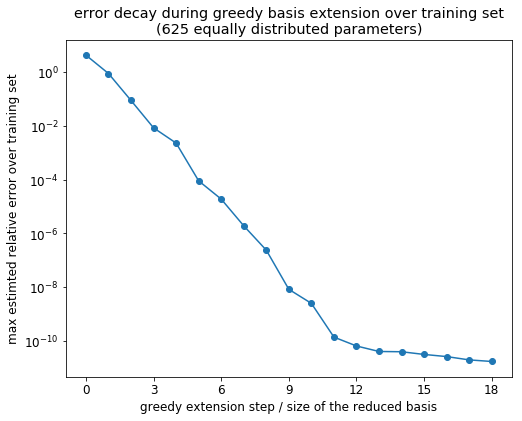

In [15]:
RB_rd = RB_greedy_data['reduced_discretization']
RB_rd.disable_logging()

plt.plot(list(range(num_RB_greedy_extensions)) + [len(range(num_RB_greedy_extensions))],
         RB_greedy_errors,
         '-o')
plt.xticks(np.arange(0, num_RB_greedy_extensions + 1, 3))
plt.yscale('log')
plt.title('error decay during greedy basis extension over training set\n({} equally distributed parameters)'.format(len(training_set)))
plt.xlabel('greedy extension step / size of the reduced basis')
plt.ylabel('max estimted relative error over training set')

Lets see which parameters the Greedy selected w.r.t. the reference quantity of interest (which he did not know).

02:30 notebook: plotting parameter values selected during the greedy ...
02:37 notebook: ... done


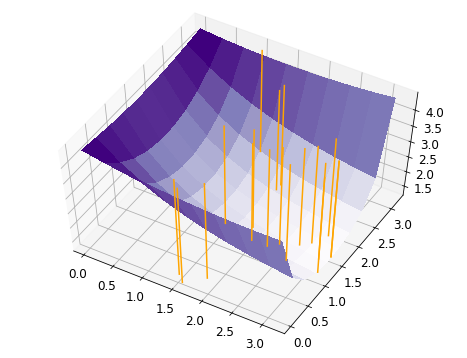

In [16]:
logger.info('plotting parameter values selected during the greedy ...')

reference_plot = plot_3d_surface(reference_quantity_of_interest, XX, YY)

for mu in RB_greedy_mus:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1])

logger.info('... done')

_Unfortunately_, the Greedy is clever enough to detect a symmetry in the parameterization.
Thus, it does "too much work", but not in the whole parameter domain.

Let us first validate that we did not destroy the quantity of interest by only using an error estimate on the solution.

02:37 notebook: plotting ...
02:44 notebook: ... done
02:44 notebook: computing some RB quantities of interest ...
02:44 notebook: ... done
02:44 notebook: relative L-infty error of QoI over training set: 5.602293042413464e-12


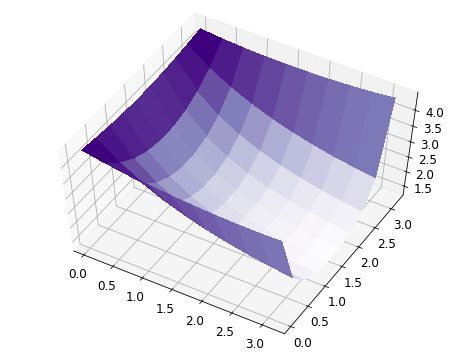

In [17]:
def RB_quantity_of_interest(mu):
    return RB_rd.rhs.apply(RB_rd.solve(mu)).data[0]

logger.info('plotting ...')
plot_3d_surface((reference_quantity_of_interest, RB_quantity_of_interest), XX, YY)
logger.info('... done')

logger.info('computing some RB quantities of interest ...')
RB_quantities_of_interest = [RB_quantity_of_interest(mu) for mu in training_set]
logger.info('... done')

logger.info('relative L-infty error of QoI over training set: {}'.format(
    (np.max(np.abs(np.array(reference_quantities_of_interest) - np.array(RB_quantities_of_interest)))
     / np.max(reference_quantities_of_interest))
))

Visually, the surfaces are indistinguishable (the RB one should be orange), but also the L-infinity error looks good.

# minimizing using the standard RB discretization

In [18]:
logger.info('minimizing reduced quantity of interest:')

RB_minimization_data = {'num_evals': 0,
                        'evaluations' : [],
                        'evaluation_points': []}

result = minimize(partial(record_results, RB_quantity_of_interest, RB_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range, parameter_range),
                  options={'ftol': 1e-15})

report(result, RB_minimization_data)

02:44 notebook: minimizing reduced quantity of interest:
02:44 notebook:  succeded!
02:44 notebook:   mu_min:    {diffusion: [1.5707964033432422, 3.141592653589793]}
02:44 notebook:   QoI(mu_min): 1.2440146064383069
02:44 notebook:   num iterations:     6
02:44 notebook:   num function calls: 21


.....................

02:44 notebook: plotting chosen points during minimization of RB quantity of interest ...
02:45 notebook: ... done


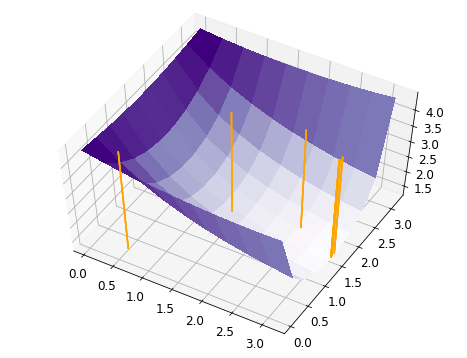

In [19]:
logger.info('plotting chosen points during minimization of RB quantity of interest ...')

RB_plot = plot_3d_surface(RB_quantity_of_interest,XX, YY)

for mu in RB_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(RB_plot, mu[0], mu[1])

logger.info('... done')

As a comparison: chosen points during the minimization of the
* reference QoI (green)
* RB QoI (orange, the same as above)
w.r.t. the reference QoI surface

02:45 notebook: plotting ...
02:52 notebook: ... done


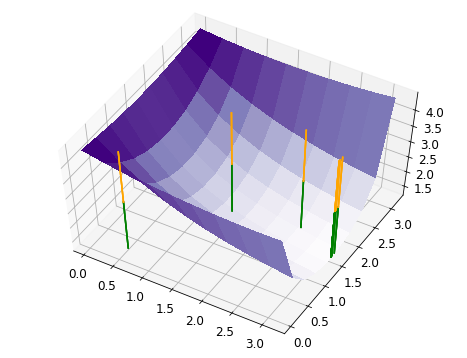

In [20]:
logger.info('plotting ...')

reference_plot = plot_3d_surface(reference_quantity_of_interest, XX, YY)
reference_plot_mean_z_lim = 0.5*(reference_plot.get_zlim()[0] + reference_plot.get_zlim()[1])

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1], color='green',
                            z_range=(reference_plot.get_zlim()[0], reference_plot_mean_z_lim))

for mu in RB_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1], color='orange',
                           z_range=(reference_plot_mean_z_lim, reference_plot.get_zlim()[1]))

logger.info('... done')

As we can see, the same points are picked by the optimizers.

In [21]:
RB_minimizer = result.x
RB_minimum = result.fun

logger.info('relative RB l-2 minimizer error: {}'.format(
    (np.linalg.norm(reference_minimizer - RB_minimizer)/np.linalg.norm(reference_minimizer))))
logger.info('relative RB l-infty QoI error:   {}'.format(
    (np.abs(reference_minimum - RB_minimum)/np.abs(reference_minimum))[0]))
logger.info('')

extended_report(RB_minimization_data)

02:52 notebook: relative RB l-2 minimizer error: 4.534160933235255e-05
02:52 notebook: relative RB l-infty QoI error:   9.013098529270765e-09
      
02:52 notebook: num_evals
02:52 notebook:   21
      
02:52 notebook: evaluations
02:52 notebook:   3.971612309293253
02:52 notebook:   3.9716122944528855
02:52 notebook:   3.971612300475223
02:52 notebook:   2.0202958506199944
02:52 notebook:   2.0202958523594345
02:52 notebook:   2.020295842875963
02:52 notebook:   1.5067762299080305
02:52 notebook:   1.5067762334433414
02:52 notebook:   1.506776226287868
02:52 notebook:   1.2482678512959713
02:52 notebook:   1.2482678521662014
02:52 notebook:   1.2482678489499026
02:52 notebook:   1.2444291253137756
02:52 notebook:   1.2444291255844726
02:52 notebook:   1.2444291229710593
02:52 notebook:   1.2440146264374758
02:52 notebook:   1.2440146264393557
02:52 notebook:   1.2440146240951224
02:52 notebook:   1.2440146064383069
02:52 notebook:   1.2440146064383073
02:52 notebook:   1.2440146040959

To conclude: using a standard RB Greedy, we require
* 18 global SWIPDG evaluations (to build the RB)
Thus
* we need 11 global SWIPDG solves more than the reference discretization, if we only compare to the 7 evaluations required by the minimizer (without the FD approximation for the gradients)
* but we save $39 - 18 = 21$ evaluations of the global SWIPDG model, since the finite difference approximation of the gradient are now performed using the RB

# setting up the LRBMS discretization

In [22]:
from lrbms import LRBMSReductor

LRBMS_reductor = LRBMSReductor(block_SWIPDG_disc,
                               products=[block_SWIPDG_disc.operators['local_energy_dg_product_{}'.format(ii)]
                                         for ii in range(block_space.num_blocks)],
                              order=0)

logger.info('... done')

02:52 LRBMSReductor: initializing local reduced bases with DG shape functions of up to order 0 ... 
02:52 notebook: ... done


In [23]:
with logger.block('reducing ...') as _:
    tt = time.time()

    LRBMS_rd = LRBMS_reductor.reduce()

logger.info('took {}s, initial reduced (LRBMS) system is of size {}x{}'.format(
    time.time() - tt,
    LRBMS_rd.solution_space.dim, LRBMS_rd.solution_space.dim))

LRBMS_reductor.disable_logging()
LRBMS_rd.disable_logging()

02:52 notebook: reducing ...
02:52 |   LRBMSReductor: Computing oswald interpolations ...
02:53 |   LRBMSReductor: Computing flux reconstructions ...
02:55 |   LRBMSReductor: Projecting local_energy_dg_product_0: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
02:55 |   LRBMSReductor: Projecting local_energy_dg_product_1: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
02:55 |   LRBMSReductor: Projecting local_energy_dg_product_2: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
02:55 |   LRBMSReductor: Projecting local_energy_dg_product_3: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
02:55 |   LRBMSReductor: Projecting local_energy_dg_product_4: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
02:55 |   LRBMSReductor: Projecting local_energy_dg_product_5: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
02:55 |   LRBMSReductor: Projecting local_energy_dg_product_6: R^96 --

02:55 |   LRBMSReductor: Projecting local_energy_dg_product_62: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
02:55 |   LRBMSReductor: Projecting local_energy_dg_product_63: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
02:55 |   LRBMSReductor: Projecting nonconformity_0: R^46464 --> R^46464  (parameter type: {}, class: BlockOperator)
02:55 |   LRBMSReductor: Projecting residual_functional_0: R^200704 --> R^1  (parameter type: {}, class: BlockOperator)
02:55 |   LRBMSReductor: Projecting residual_0: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
02:55 |   LRBMSReductor: Projecting diffusive_flux_aa_0: R^6144 --> R^6144  (parameter type: {}, class: LincombOperator)
02:56 |   LRBMSReductor: Projecting diffusive_flux_bb_0: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
02:56 |   LRBMSReductor: Projecting diffusive_flux_ab_0: R^200704 --> R^6144  (parameter type: {diffusion: (2,)}, class: LincombOperator)
02:56

03:10 |   LRBMSReductor: Projecting nonconformity_11: R^46464 --> R^46464  (parameter type: {}, class: BlockOperator)
03:10 |   LRBMSReductor: Projecting residual_functional_11: R^200704 --> R^1  (parameter type: {}, class: BlockOperator)
03:10 |   LRBMSReductor: Projecting residual_11: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:10 |   LRBMSReductor: Projecting diffusive_flux_aa_11: R^6144 --> R^6144  (parameter type: {}, class: LincombOperator)
03:11 |   LRBMSReductor: Projecting diffusive_flux_bb_11: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:11 |   LRBMSReductor: Projecting diffusive_flux_ab_11: R^200704 --> R^6144  (parameter type: {diffusion: (2,)}, class: LincombOperator)
03:11 |   LRBMSReductor: Projecting nonconformity_12: R^46464 --> R^46464  (parameter type: {}, class: BlockOperator)
03:11 |   LRBMSReductor: Projecting residual_functional_12: R^200704 --> R^1  (parameter type: {}, class: BlockOperator)
03:11 |   LRBMSReducto

03:25 |   LRBMSReductor: Projecting residual_functional_22: R^200704 --> R^1  (parameter type: {}, class: BlockOperator)
03:25 |   LRBMSReductor: Projecting residual_22: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:25 |   LRBMSReductor: Projecting diffusive_flux_aa_22: R^6144 --> R^6144  (parameter type: {}, class: LincombOperator)
03:26 |   LRBMSReductor: Projecting diffusive_flux_bb_22: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:26 |   LRBMSReductor: Projecting diffusive_flux_ab_22: R^200704 --> R^6144  (parameter type: {diffusion: (2,)}, class: LincombOperator)
03:27 |   LRBMSReductor: Projecting nonconformity_23: R^46464 --> R^46464  (parameter type: {}, class: BlockOperator)
03:27 |   LRBMSReductor: Projecting residual_functional_23: R^200704 --> R^1  (parameter type: {}, class: BlockOperator)
03:27 |   LRBMSReductor: Projecting residual_23: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:27 |   LRBMSReductor: 

03:40 |   LRBMSReductor: Projecting residual_33: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:41 |   LRBMSReductor: Projecting diffusive_flux_aa_33: R^6144 --> R^6144  (parameter type: {}, class: LincombOperator)
03:41 |   LRBMSReductor: Projecting diffusive_flux_bb_33: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:41 |   LRBMSReductor: Projecting diffusive_flux_ab_33: R^200704 --> R^6144  (parameter type: {diffusion: (2,)}, class: LincombOperator)
03:42 |   LRBMSReductor: Projecting nonconformity_34: R^46464 --> R^46464  (parameter type: {}, class: BlockOperator)
03:42 |   LRBMSReductor: Projecting residual_functional_34: R^200704 --> R^1  (parameter type: {}, class: BlockOperator)
03:42 |   LRBMSReductor: Projecting residual_34: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:42 |   LRBMSReductor: Projecting diffusive_flux_aa_34: R^6144 --> R^6144  (parameter type: {}, class: LincombOperator)
03:43 |   LRBMSReductor:

03:55 |   LRBMSReductor: Projecting diffusive_flux_aa_44: R^6144 --> R^6144  (parameter type: {}, class: LincombOperator)
03:56 |   LRBMSReductor: Projecting diffusive_flux_bb_44: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:56 |   LRBMSReductor: Projecting diffusive_flux_ab_44: R^200704 --> R^6144  (parameter type: {diffusion: (2,)}, class: LincombOperator)
03:56 |   LRBMSReductor: Projecting nonconformity_45: R^46464 --> R^46464  (parameter type: {}, class: BlockOperator)
03:56 |   LRBMSReductor: Projecting residual_functional_45: R^200704 --> R^1  (parameter type: {}, class: BlockOperator)
03:56 |   LRBMSReductor: Projecting residual_45: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:56 |   LRBMSReductor: Projecting diffusive_flux_aa_45: R^6144 --> R^6144  (parameter type: {}, class: LincombOperator)
03:57 |   LRBMSReductor: Projecting diffusive_flux_bb_45: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
03:57 |   LRBMS

04:11 |   LRBMSReductor: Projecting diffusive_flux_bb_55: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
04:11 |   LRBMSReductor: Projecting diffusive_flux_ab_55: R^200704 --> R^6144  (parameter type: {diffusion: (2,)}, class: LincombOperator)
04:11 |   LRBMSReductor: Projecting nonconformity_56: R^46464 --> R^46464  (parameter type: {}, class: BlockOperator)
04:12 |   LRBMSReductor: Projecting residual_functional_56: R^200704 --> R^1  (parameter type: {}, class: BlockOperator)
04:12 |   LRBMSReductor: Projecting residual_56: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
04:12 |   LRBMSReductor: Projecting diffusive_flux_aa_56: R^6144 --> R^6144  (parameter type: {}, class: LincombOperator)
04:12 |   LRBMSReductor: Projecting diffusive_flux_bb_56: R^200704 --> R^200704  (parameter type: {}, class: BlockOperator)
04:12 |   LRBMSReductor: Projecting diffusive_flux_ab_56: R^200704 --> R^6144  (parameter type: {diffusion: (2,)}, class: LincombOperator

# minimizing using the LRBMS discretization

## using the (insufficient) initial zero-order basis

06:39 notebook: plotting ...
06:47 notebook: ... done
06:47 notebook: computing some zero order LRBMS reduced quantities of interest ...
06:48 notebook: relative L-infty error w.r.t. reference QoI: 0.945021037261154


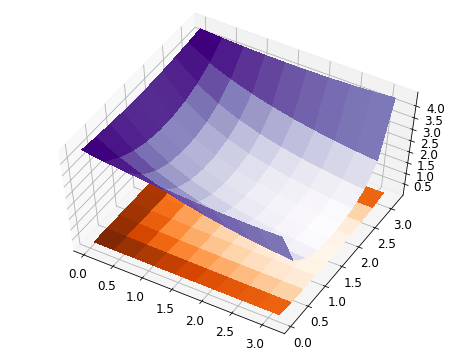

In [24]:
logger.info('plotting ...')

def LRBMS_0_quantity_of_interest(mu):
    return LRBMS_rd.rhs.apply(LRBMS_rd.solve(mu)).data[0]

plot_3d_surface((reference_quantity_of_interest, LRBMS_0_quantity_of_interest), XX, YY)

logger.info('... done')
logger.info('computing some zero order LRBMS reduced quantities of interest ...')

LRBMS_0_quantities_of_interest = [LRBMS_0_quantity_of_interest(mu) for mu in training_set]

logger.info('relative L-infty error w.r.t. reference QoI: {}'.format(
    (np.max(np.abs(np.array(reference_quantities_of_interest) - np.array(LRBMS_0_quantities_of_interest)))
     /np.max(np.abs(reference_quantities_of_interest)))
))

As we can see, the LRBMS-0-order basis QoI (bottom) is far away from the reference QoI (top), also the relative $l_\infty-l_\infty$ error is $94.5\%$.
But we can try to minimize never-the-less:

In [25]:
logger.info('minimizing order-0 LRBMS quantity of interest ...')

LRBMS_0_minimization_data = {'num_evals': 0,
                             'evaluations' : [],
                             'evaluation_points': []}

result = minimize(partial(record_results, LRBMS_0_quantity_of_interest, LRBMS_0_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range, parameter_range),
                  options={'ftol': 1e-15})

report(result, LRBMS_0_minimization_data)

LRBMS_0_minimizer = result.x
LRBMS_0_minimum = result.fun

logger.info('')
logger.info('relative LRBMS (order-0) l-2 minimizer error: {}'.format(
    (np.linalg.norm(reference_minimizer - LRBMS_0_minimizer)/np.linalg.norm(reference_minimizer))))
logger.info('relative LRBMS (order-0) l-infty QoI error:   {}'.format(
    (np.abs(reference_minimum - LRBMS_0_minimum)/np.abs(reference_minimum))[0]))
logger.info('')

extended_report(LRBMS_0_minimization_data)

06:48 notebook: minimizing order-0 LRBMS quantity of interest ...
06:48 notebook:  succeded!
06:48 notebook:   mu_min:    {diffusion: [1.570633249972388, 3.141592653589793]}
06:48 notebook:   QoI(mu_min): 0.06650507730437835
06:48 notebook:   num iterations:     7
06:48 notebook:   num function calls: 30
      
06:48 notebook: relative LRBMS (order-0) l-2 minimizer error: 9.179125022757327e-05
06:48 notebook: relative LRBMS (order-0) l-infty QoI error:   0.9465399551092332
      
06:48 notebook: num_evals
06:48 notebook:   30
      
06:48 notebook: evaluations
06:48 notebook:   0.21921607063403353
06:48 notebook:   0.21921606980255703
06:48 notebook:   0.2192160701583435
06:48 notebook:   0.2098899572784674
06:48 notebook:   0.20988995646481745
06:48 notebook:   0.20988995671805546
06:48 notebook:   0.2000520669538418
06:48 notebook:   0.20005206616518
06:48 notebook:   0.2000520663378181
06:48 notebook:   0.1628067229515525
06:48 notebook:   0.16280672237572352
06:48 notebook:   0.162

..............................

While the relative error in the QoI is $94.65\%$, the minimizing parameter (arg min) is already very close (a relative $l_2$-error of $9\cdot10^{-5}$). This is due to the fact that while the LRBMS-0-order QoI surface is far away from the reference QoI surface, the shape is comparable. We can see this by plotting the LRBMS-0-order surface standalone, with rescaled axes (mind the z-axes limits when comparing to one of the plots above):

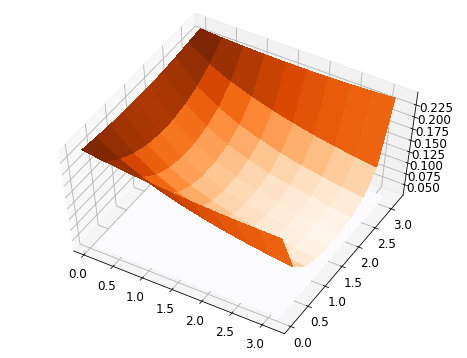

In [26]:
# we plot the constant function first to ensure the same colormap for the 0-order surface
plot_3d_surface((lambda mu: 0.03, LRBMS_0_quantity_of_interest), XX, YY)

To conclude: if we are "only" interested in the minimizing parameter, and if we had an a posteriori error estimate for detection, the online enrichment would not even start and the 0-order basis would be sufficient.
We did not require any global SWIPDG evaluations here.

## using the adaptive online enrichment

In [27]:
logger.info('minimizing adaptive LRBMS quantity of interest ...')
logger.info('')

LRBMS_reductor.disable_logging()

from online_enrichment import AdaptiveEnrichment

config['marking_doerfler_theta'] = 0.85
config['marking_max_age'] = 3

online_adaptive_LRBMS = AdaptiveEnrichment(grid_and_problem_data,
                                           block_SWIPDG_disc, block_space,
                                           LRBMS_reductor, LRBMS_rd,
                                           config['enrichment_target_error'],
                                           config['marking_doerfler_theta'],
                                           config['marking_max_age'])

set_log_levels({'pymor.algorithms.gram_schmidt': 'WARN'})

adaptive_LRBMS_minimization_data = {'num_evals': 0,
                                    'evaluation_points': [],
                                    'evaluations' : [],
                                    'intermediate_evaluations' : [],
                                    'intermediate_evaluation_points': [],
                                    'num_local_solves': []}


def adaptive_LRBMS_quantity_of_interest(mu):
    
    num_solves = [0]
    
    def callback(rd_, U_, mu_, data_):
        # we need to copy the data here, since the added mu is changed inplace by minimize afterwards
        adaptive_LRBMS_minimization_data['intermediate_evaluation_points'].append(
            [mu_['diffusion'][0], mu_['diffusion'][1]])
        QoI = rd_.rhs.apply(U_).data[0]
        adaptive_LRBMS_minimization_data['intermediate_evaluations'].append(QoI)
        num_solves[0] += data_['local_problem_solves']

    mu = parse_parameter(mu)
    U, rd, _ = online_adaptive_LRBMS.solve(mu, callback=callback)
    
    adaptive_LRBMS_minimization_data['num_local_solves'].append(num_solves[0])
    
    return rd.rhs.apply(U).data[0]


result = minimize(partial(record_results,
                          adaptive_LRBMS_quantity_of_interest,
                          adaptive_LRBMS_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range, parameter_range),
                  options={'ftol': 1e-15})

logger.info('')
report(result, adaptive_LRBMS_minimization_data)

06:49 notebook: minimizing adaptive LRBMS quantity of interest ...
      
06:49 AdaptiveEnrichment: solving 64-dimensional system for mu = {diffusion: [0.25, 0.5]} ...
06:49 |   |INFO3|AdaptiveEnrichment: estimated error 4.378925579807537 above target error of 0.20200122686893573, enriching ...
06:49 |   |INFO3|AdaptiveEnrichment: marked 33/64 subdomains due to Dörfler marking
06:49 |   |INFO3|AdaptiveEnrichment:    and 0/31 additionally due to age marking
06:49 |   |INFO3|AdaptiveEnrichment: solving local corrector problems on 33 subdomains ...


.

06:49 |   AdaptiveEnrichment: reducing ...
10:23 |   |INFO3|AdaptiveEnrichment: added 33 local basis functions, system size increase: 64 --> 97
10:23 |   |INFO3|AdaptiveEnrichment: estimated error 7.4005555502486455 above target error of 0.20200122686893573, enriching ...
10:23 |   |INFO3|AdaptiveEnrichment: marked 14/64 subdomains due to Dörfler marking
10:23 |   |INFO3|AdaptiveEnrichment:    and 0/50 additionally due to age marking
10:23 |   |INFO3|AdaptiveEnrichment: solving local corrector problems on 14 subdomains ...
10:24 |   AdaptiveEnrichment: reducing ...
14:16 |   |INFO3|AdaptiveEnrichment: added 14 local basis functions, system size increase: 97 --> 111
14:16 |   |INFO3|AdaptiveEnrichment: estimated error 6.472437752475843 above target error of 0.20200122686893573, enriching ...
14:16 |   |INFO3|AdaptiveEnrichment: marked 12/64 subdomains due to Dörfler marking
14:16 |   |INFO3|AdaptiveEnrichment:    and 0/52 additionally due to age marking
14:16 |   |INFO3|AdaptiveEnrichme

01:06:43 AdaptiveEnrichment: solving 409-dimensional system for mu = {diffusion: [0.25000001, 0.5]} ...
01:06:43 |   |INFO3|AdaptiveEnrichment: estimated error 0.20014441065368732 below target error of 0.20200122686893573, no enrichment required ...
01:06:43 AdaptiveEnrichment: solving 409-dimensional system for mu = {diffusion: [0.25, 0.50000001]} ...
01:06:43 |   |INFO3|AdaptiveEnrichment: estimated error 0.20014441127453045 below target error of 0.20200122686893573, no enrichment required ...
01:06:43 AdaptiveEnrichment: solving 409-dimensional system for mu = {diffusion: [1.7339301787361592, 1.3818065388993546]} ...


...

01:06:44 |   |INFO3|AdaptiveEnrichment: estimated error 0.23185401467145728 above target error of 0.20200122686893573, enriching ...
01:06:44 |   |INFO3|AdaptiveEnrichment: marked 6/64 subdomains due to Dörfler marking
01:06:44 |   |INFO3|AdaptiveEnrichment:    and 0/58 additionally due to age marking
01:06:44 |   |INFO3|AdaptiveEnrichment: solving local corrector problems on 6 subdomains ...
01:06:44 |   AdaptiveEnrichment: reducing ...
01:10:56 |   |INFO3|AdaptiveEnrichment: added 6 local basis functions, system size increase: 409 --> 415
01:10:57 |   |INFO3|AdaptiveEnrichment: estimated error 0.1715572451444373 below target error of 0.20200122686893573, no enrichment required ...
01:10:57 AdaptiveEnrichment: solving 415-dimensional system for mu = {diffusion: [1.7339301887361591, 1.3818065388993546]} ...
01:10:57 |   |INFO3|AdaptiveEnrichment: estimated error 0.17155724507569672 below target error of 0.20200122686893573, no enrichment required ...
01:10:57 AdaptiveEnrichment: solvin

...

01:10:57 |   AdaptiveEnrichment: reducing ...
01:14:53 |   |INFO3|AdaptiveEnrichment: added 6 local basis functions, system size increase: 415 --> 421
01:14:53 |   |INFO3|AdaptiveEnrichment: estimated error 0.14906997822922036 below target error of 0.20200122686893573, no enrichment required ...
01:14:53 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.9224067300202519, 2.442473178455679]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.14906997829914556 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.922406720020252, 2.4424731884556787]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.1490699786815963 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.669143694814106, 3.141592653589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichm

....

01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.18632949092634604 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.669143694814106, 3.141592663589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.1863294915099682 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.6018271447257386, 3.141592653589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.1860349174070527 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.6018271547257386, 3.141592653589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.186034917428511 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-di

....

01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.1860349180536156 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.5710150077714549, 3.141592653589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.18600236919850796 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.5710150177714548, 3.141592653589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.18600236919883256 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.5710150077714549, 3.141592663589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.18600236984448312 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 42

....

01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.18600236758208857 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.5707965387970209, 3.141592653589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.18600236758223054 below target error of 0.20200122686893573, no enrichment required ...
01:14:54 AdaptiveEnrichment: solving 421-dimensional system for mu = {diffusion: [1.570796528797021, 3.141592663589793]} ...
01:14:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.18600236822787497 below target error of 0.20200122686893573, no enrichment required ...
         
01:14:54 notebook:  succeded!
01:14:54 notebook:   mu_min:    {diffusion: [1.570796528797021, 3.141592653589793]}
01:14:54 notebook:   QoI(mu_min): 1.240820384391876
01:14:54 notebook:   num iterations:     6
01:14:54 notebook:   num function calls: 21


..

In [28]:
adaptive_LRBMS_minimizer = result.x
adaptive_LRBMS_minimum = result.fun

logger.info('')
logger.info('relative LRBMS (adaptive) minimizer error: {}'.format(
    (np.linalg.norm(reference_minimizer - adaptive_LRBMS_minimizer)/np.linalg.norm(reference_minimizer))))
logger.info('relative LRBMS (adaptive) QoI error:   {}'.format(
    (np.abs(reference_minimum - adaptive_LRBMS_minimum)/np.abs(reference_minimum))[0]))

         
01:14:54 notebook: relative LRBMS (adaptive) minimizer error: 4.530589273674071e-05
01:14:54 notebook: relative LRBMS (adaptive) QoI error:   0.0025676814512754107


Lets take a look at the selected mus during the minimization.
* the orange bars indicate the mus selcted by the minimizer
* the orange dots indicate the computed QoI during the adaptive enrichment (these are not returned to the minimizer, larger ones were computed first)
* the purple dots indicate those values of the QoI returned to the minimizer

(array([ 0.21921607]), 4.42022848)

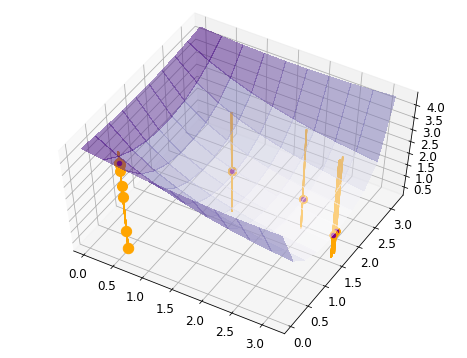

In [29]:
fig = plt.figure()
ax = fig.gca(projection='3d')

x, y, f_of_x = compute_value_matrix(reference_quantity_of_interest, XX, YY)
ax.plot_surface(x, y, f_of_x, cmap='Purples', linewidth=0, antialiased=False, alpha=0.5)

intermediate_mus = list(adaptive_LRBMS_minimization_data['intermediate_evaluation_points'])
intermediate_QoIs = list(adaptive_LRBMS_minimization_data['intermediate_evaluations'])
sizes = 40*np.exp(np.linspace(1, 0.01, len(intermediate_mus)))

for ii in range(len(intermediate_mus)):
    mu = intermediate_mus[ii]
    QoI = intermediate_QoIs[ii]
    addplot_xy_point_as_bar(ax, mu[0], mu[1])
    # x and y need to be interchanged here to match the surface plot
    ax.scatter(mu[1], mu[0], QoI, c='orange',s=sizes[ii])

mus = list(adaptive_LRBMS_minimization_data['evaluation_points'])
QoIs = list(adaptive_LRBMS_minimization_data['evaluations'])

for ii in range(len(mus)):
    mu = mus[ii]
    QoI = QoIs[ii]
    addplot_xy_point_as_bar(ax, mu[0], mu[1])
    # x and y need to be interchanged here to match the surface plot
    ax.scatter(mu[1], mu[0], QoI, c='purple')

ax.view_init(elev=57.7597402597, azim=-59.6370967742)
ax.set_xlim3d([-0.10457963, 3.2961723])
ax.set_ylim3d([-0.10457963, 3.29617229])
intermediate_QoIs.append(1.21122592)
intermediate_QoIs.append(4.42022848)
ax.set_zlim3d([np.min(intermediate_QoIs), np.max(intermediate_QoIs)])

In [30]:
extended_report(adaptive_LRBMS_minimization_data)

logger.info('total num_local_solves: {}'.format(np.sum(adaptive_LRBMS_minimization_data['num_local_solves'])))

01:15:02 notebook: num_evals
01:15:02 notebook:   21
         
01:15:02 notebook: evaluation_points
01:15:02 notebook:   [0.25, 0.5]
01:15:02 notebook:   [0.25000000999999999, 0.5]
01:15:02 notebook:   [0.25, 0.50000001000000005]
01:15:02 notebook:   [1.7339301787361592, 1.3818065388993546]
01:15:02 notebook:   [1.7339301887361591, 1.3818065388993546]
01:15:02 notebook:   [1.7339301787361592, 1.3818065488993545]
01:15:02 notebook:   [1.9224067200202519, 2.4424731784556788]
01:15:02 notebook:   [1.9224067300202519, 2.4424731784556788]
01:15:02 notebook:   [1.9224067200202519, 2.4424731884556787]
01:15:02 notebook:   [1.6691436948141061, 3.1415926535897931]
01:15:02 notebook:   [1.669143704814106, 3.1415926535897931]
01:15:02 notebook:   [1.6691436948141061, 3.1415926635897931]
01:15:02 notebook:   [1.6018271447257386, 3.1415926535897931]
01:15:02 notebook:   [1.6018271547257386, 3.1415926535897931]
01:15:02 notebook:   [1.6018271447257386, 3.1415926635897931]
01:15:02 notebook:   [1.571

Lets take a look at the size of the local reduced basis at the end of the simulation.

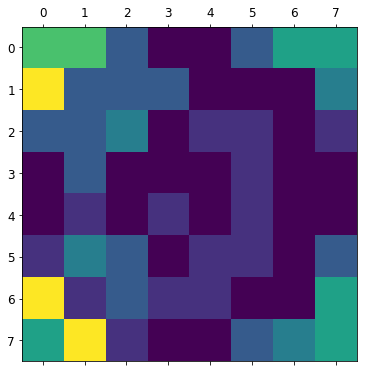

In [31]:
subdomains = config['num_coarse_grid_elements']
basis_sizes = np.ones(subdomains)
counter = 0
for ii in range(subdomains[0]):
    for jj in range(subdomains[1]):
        basis_sizes[subdomains[0] - 1 - ii][jj] = len(online_adaptive_LRBMS.reductor.bases['domain_{}'.format(counter)])
        counter += 1
plt.matshow(basis_sizes)

To conclude: using the online adaptive LRBMS with an initial $Q^0$ basis
* finds the minimizer up to a relative $l_2$-error of 4.53e-05
* finds the minimum up to a relative error of $0.257\%$
* needs 0 global SWIPDG evaluations
* needs 357 local corrector problem solutions
* the sizes of the final local reduced bases indicate the spatial influence of the parameter dependency

The approximation of the QoI could be improved, since we use a (parameter-)global target tolerance for the online enrichment, while the error varies throughout the parameter domain. Thus, for the minimum we stop the enrichment too early...